In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
date_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

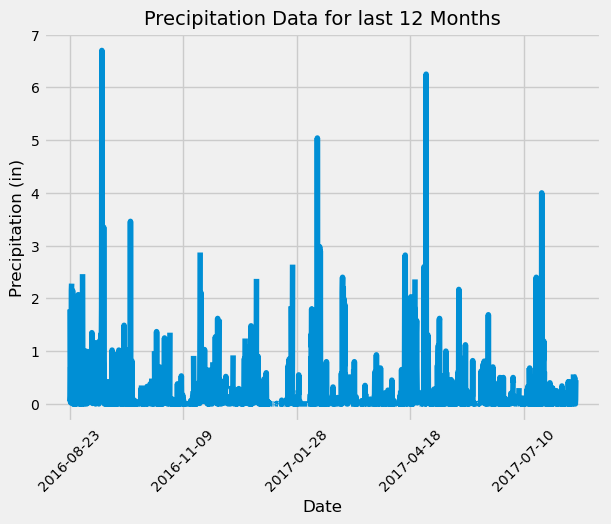

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
data_recent = session.query(Measurement.date, Measurement.prcp).\
                      order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
d = dt.datetime.strptime(data_recent.date, "%Y-%m-%d")
last_date = d.date() - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= last_date).\
                all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns = ['Date', 'Precipitation'])
df = df.set_index('Date')

# Sort the dataframe by date
df_sorted = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted['Precipitation'].plot(rot = 45)
plt.ylabel('Precipitation (in)', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Date', fontsize = 12)
plt.title('Precipitation Data for last 12 Months', fontsize = 14)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
number_stations = len(session.query(Station.station).all())
number_stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.station)]

ordered_stations = session.query(*sel).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).\
                    all()

ordered_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.max(Measurement.tobs),
       func.min(Measurement.tobs),
       func.avg(Measurement.tobs)]

active_station_stats = session.query(*sel).\
                        filter(Measurement.station == ordered_stations[0][0]).\
                        all()

print(f'The most active station is {active_station_stats[0][0]}')
print(f'It has the highest temperature of {active_station_stats[0][1]} F')
print(f'It has the lowest temperature of {active_station_stats[0][2]} F')
print(f'It has an average temperature of {active_station_stats[0][3]:.2f} F')

The most active station is USC00519281
It has the highest temperature of 85.0 F
It has the lowest temperature of 54.0 F
It has an average temperature of 71.66 F


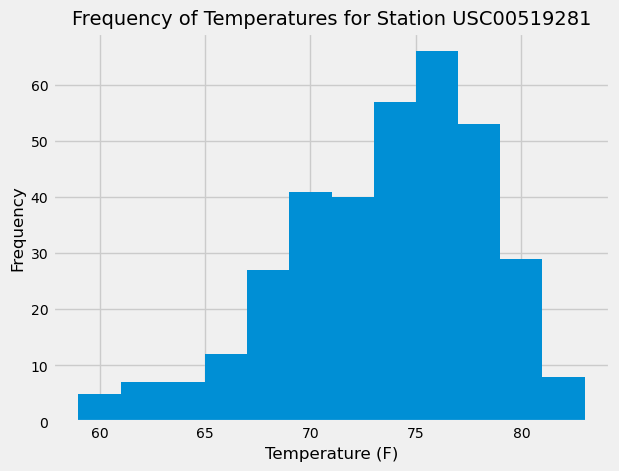

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
                        filter(Measurement.station == ordered_stations[0][0]).\
                        filter(func.strftime("%Y-%m-%d", Measurement.date) >= last_date).\
                        all()
df_temp = pd.DataFrame(results)
df_temp.plot.hist(bins = 12, legend = False)
plt.xlabel('Temperature (F)', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Frequency', fontsize = 12)
plt.title(f'Frequency of Temperatures for Station {active_station_stats[0][0]}', fontsize = 14)
plt.show()

# Close session

In [16]:
# Close Session
session.close()